# 0. Применение метода KNN для решения задачи классификации

Набор данных получен в результате переписи населения 1994 года и содержит информацию о некотором количестве людей, проживающих в США. Задача состоит в том, чтобы предсказать, зарабатывает человек более $50к в год или нет. Список признаков:

*   <b>age</b>: возраст человека.
*   <b>workclass</b>: статус занятости.
*   <b>fnlwgt</b>: количество людей, которое, по мнению переписи, представляет запись.
*   <b>education</b>: высший уровень образования, достигнутый человеком.
*   <b>education-num</b>: высший уровень образования, достигнутый человеком в числовой форме.
*   <b>marital-status</b>: семейное положение человека.
*   <b>occupation</b>: общий род занятий человека.
*   <b>relationship</b>: представляет то, чем этот человек является по отношению к другим (перекликается с признаком <b>marital-status</b>).
*   <b>race</b>: раса.
*   <b>sex</b>: пол.
*   <b>capital-gain</b>: прирост капитала.
*   <b>capital-loss</b>: убыток капитала.
*   <b>hours-per-week</b>: число рабочих часов в неделю.
*   <b>native-country</b>: страна происхождения.
*   <b>the label</b>: отклик -- зарабатывает больше $50к или меньше.



## Немного про метрики качества модели

Для начала рассмотрим так называемую матрицу ошибок (confusion matrix)
-- способ разделить объекты на $4$ группы в зависимости от комбинации
истинного класса и ответа классификатора:

-   TP (True Positives) -- верно классифицированные объекты, исходно     относящиеся к классу "$+1$";

-   TN (True Negatives) -- верно классифицированные объекты, исходно     относящиеся к классу "$-1$";

-   FN (False Negatives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$+1$" (ошибка I рода);

-   FP (False Positives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$-1$" (ошибка II рода).

Обычно, конечно, оперируют не абсолютными показателями, а относительными
-- долями (rates), находящимися в диапазоне от $0$ до $1$:

-   доля правильных ответов классификатора (иногда -- точность): $$\mathsf{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}.$$ Эта величина показывает отношение количества верно классифицированных объектов к общему количеству классифицируемых объектов и, грубо говоря, оценивает вероятность случайному объекту быть правильно классифицированным.

-   доля истинно положительных примеров -- True Positives Rate (TPR) или     Sensitivity (чувствительность) или Recall: $$\mathsf{T P R}=\frac{T P}{T P+F N}.$$ Эта величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$+1$", к общему количеству объектов класса "$+1$". Иными словами -- это оценка вероятности, что объект, относящийся к классу "$+1$" будет классифицирован корректно.

-   доля ложно положительных примеров обозначается как -- False Positives Rate (FPR): $$\mathsf{F P R}=\frac{F P}{FP + TN}.$$ Величина показывает отношение количества неверно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован неверно.

-   Специфичность (Specificity) или True Negatives Rate (TNR): $$\mathsf{TNR} = 1 - \mathsf{F P R} =\frac{T N}{T N+F P}.$$ Величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован верно.

-   Precision (точность): $$\mathsf{Precision} =\frac{TP}{TP + FP}.$$ Величина показывает, какая доля объектов, отнесенных классификатором к классу "$+1$", действительно относится к этому классу.

Естественно возникает вопрос, нет ли какого-то обобщающего критерия,
который может характеризовать качество построенной модели. Один из них --
так называемая $F$-мера ($F_1$-мера, $F$ score, $F_1$ score)
определяется следующим соотношением:
$$F = F_1 = 2 \cdot \frac{\mathsf{Precision} \cdot \mathsf{Recall}}{\mathsf{Precision} + \mathsf{Recall}}.$$

**Замечание**. *$F$-мера является средним гармоническим величин
$\mathsf{Precision}$ и $\mathsf{Recall}$ и заключена в диапазоне
$[0, 1]$. Среднее гармоническое обладает важным свойством: оно близко к
нулю, если хотя бы один из аргументов близок к нулю. Поэтому оно является
куда более предпочтительным, чем, скажем, среднее арифметическое: если
алгоритм относит все объекты к положительному классу, то
$\mathsf{Recall}= 1$, а $\mathsf{Precision}$, скорее всего, будет
небольшим. Но тогда среднее арифметическое будет больше, чем $0.5$, что,
конечно, никуда не годится.*

## Импорт библиотек и чтение набора данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot as plt

Считайте набор данных в датафрейм. Исходя из описания признаков можно сразу избавиться от признаков <code>education</code> и <code>marital-status</code>. Удалите соответствующие колонки из набора данных.

In [2]:
df = pd.read_csv('https://courses.openedu.ru/assets/courseware/v1/3b5e697be14f493785e3d21577f9fcb3/asset-v1:ITMOUniversity+MLDATAN+spring_2024_ITMO_bac+type@asset+block/adult_data_train.csv')

df = df.drop(columns=['education', 'marital-status'])

Определите количество числовых и нечисловых признаков.

In [3]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education-num      int64
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
label              int64
dtype: object



---



> Числовых = 7



> Нечисловых = 6



---



Постройте гистограмму распределения объектов по классам. Вычислите долю объектов класса $0$.

<Axes: xlabel='label', ylabel='count'>

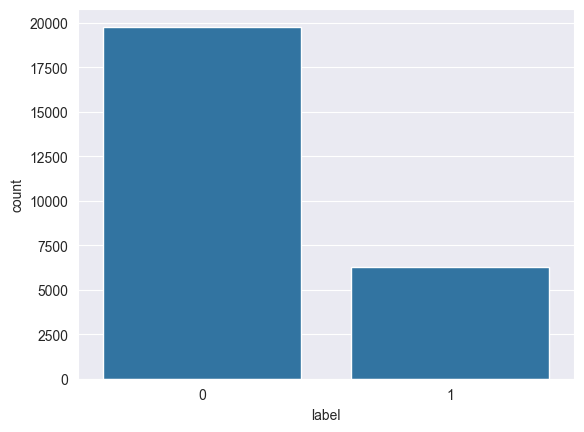

In [4]:
sns.countplot(df, x='label')

In [5]:
df['label'].value_counts(normalize=True)[0]

0.7591753685503686

# 1. Построение базовой модели

В качестве первого приближения имеет смысл построить модель классификации, опираясь исключительно на числовые признаки.

Отберите из набора данных только числовые признаки. При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки <b>с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>label</code>.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных.

Обучите модель <code>KNeighborsClassifier()</code> с параметрами по умолчанию на тренировочных данных.

Как видно из предыдущего пункта, в наборе данных наблюдается явный дисбаланс представителей классов. Это следует учесть при оценке модели. Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.

В качестве альтернативы можно использовать так называемый <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html"><code>classification_report()</code></a>, где приведены сразу несколько метрик (не стоит забывать про параметр <code>digits</code>).

In [6]:
df_num = df[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'label']]
df_cat = df.drop(columns=df_num.columns)

X_train, X_test, y_train, y_test = train_test_split(
    df_num.drop(columns=['label']), df_num[['label']], test_size=0.2, random_state=11, stratify=df_num['label'])

In [7]:
X_train['fnlwgt'].mean()

190043.75909396296

In [8]:
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [9]:
prediction = neigh.predict(X_test)

f1_score(y_test, prediction)

0.36929460580912865

Стоит помнить, что KNN является метрическим классификатором, поэтому значения признаков перед обучением модели следует нормировать.

Обучите преобразование <code>MinMaxScaler()</code> на тренировочном наборе данных и примените его для тренировочных и тестовых данных.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных после нормировки.

Заново обучите и оцените модель на преобразованных данных. Вычислите <code>f1_score()</code> модели.

In [10]:
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X_train['fnlwgt'].mean()

0.1207255804009474

In [11]:
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)

prediction = neigh.predict(X_test)
f1_score(y_test, prediction)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.509460083064144

Видно, что после линейной нормировки качество выросло.

<b>Важно: </b>На дальнейших этапах подразумевается использование линейной нормировки непосредственно перед обучением без дополнительных напоминаний.

# 2. Работа с нечисловыми признаками

## Визуализация

Для дальнейшего улучшения качества модели имеет смысл задействовать нечисловые признаки исходного датасета (без колонок <code>education</code> и <code>marital-status</code>).

Постройте гистограммы, иллюстрирующие частоту того или иного значения по каждому нечисловому признаку, например, при помощи <code>sns.barplot()</code>.

<Axes: xlabel='workclass', ylabel='count'>

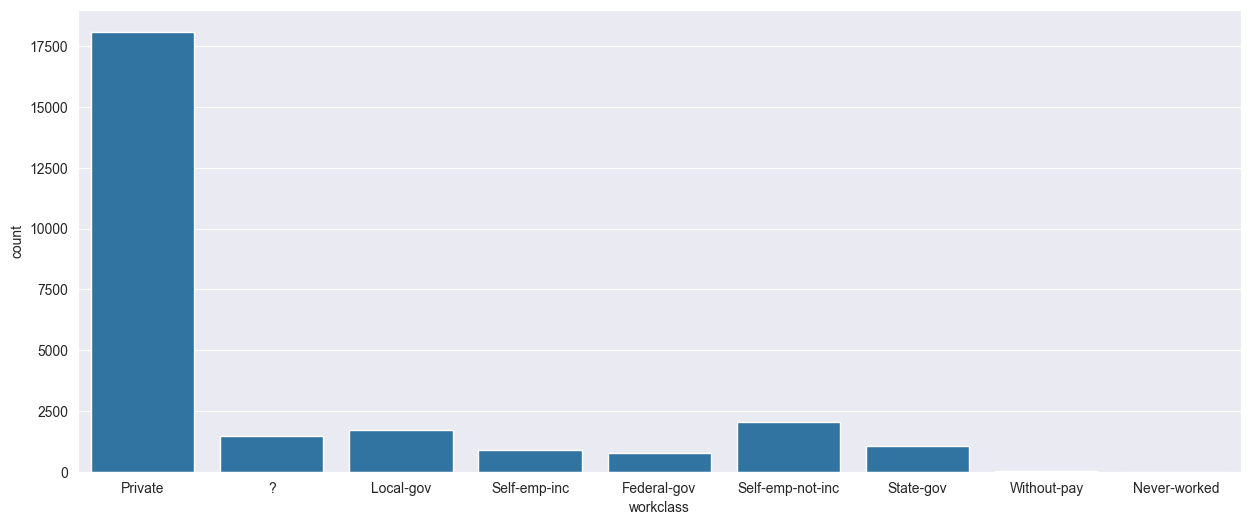

In [12]:
plt.figure(figsize=(15, 6))
sns.countplot(df_cat, x='workclass')

<Axes: xlabel='occupation', ylabel='count'>

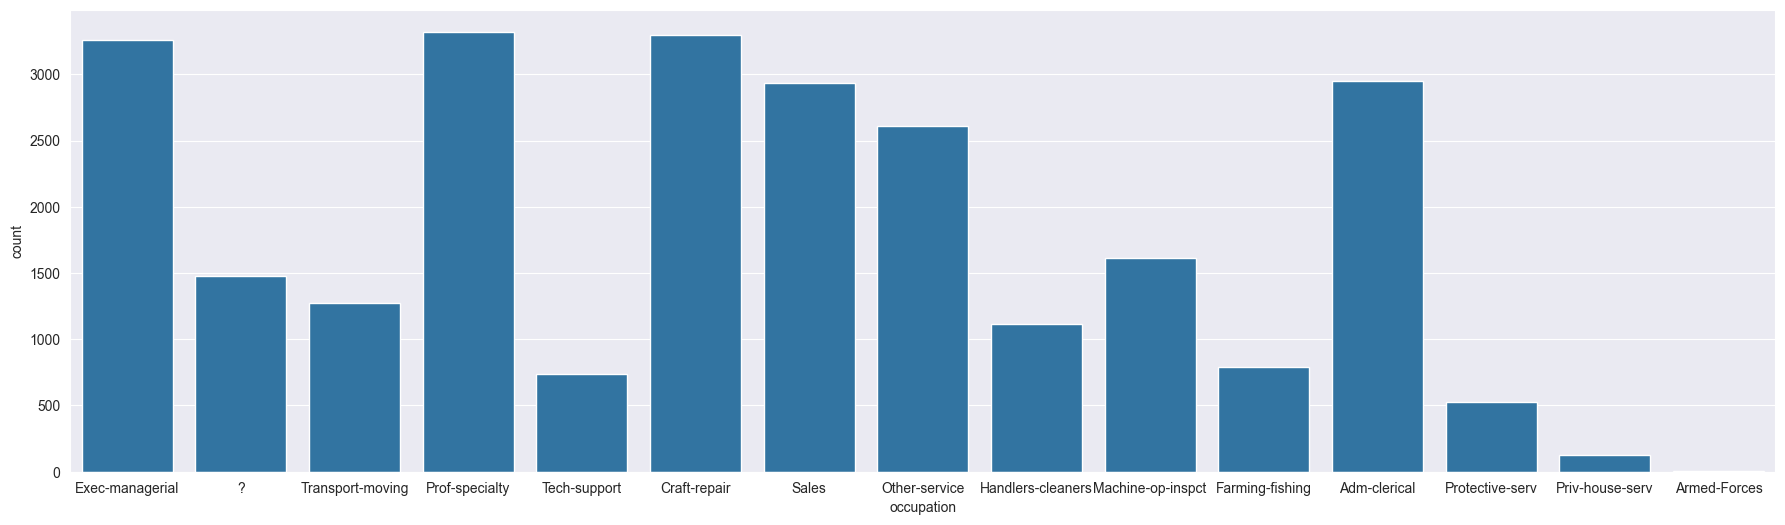

In [13]:
plt.figure(figsize=(22, 6))
sns.countplot(df_cat, x='occupation')

<Axes: xlabel='relationship', ylabel='count'>

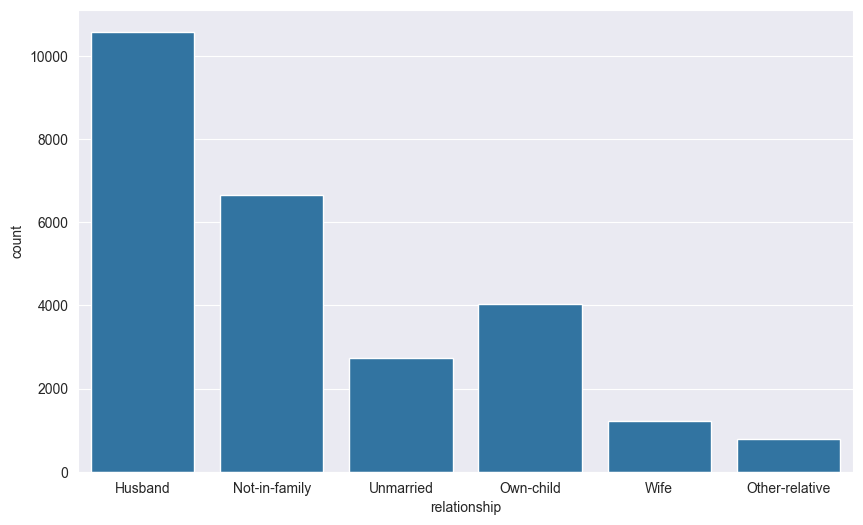

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(df_cat, x='relationship')

<Axes: xlabel='race', ylabel='count'>

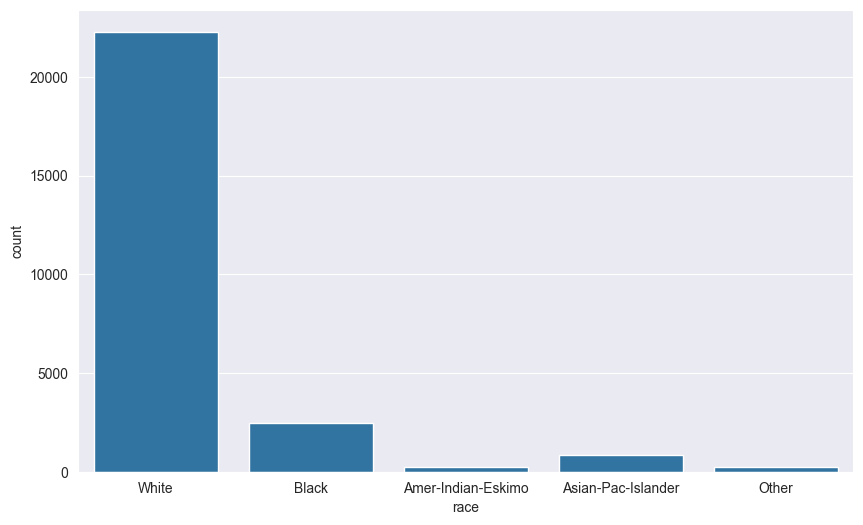

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(df_cat, x='race')

<Axes: xlabel='sex', ylabel='count'>

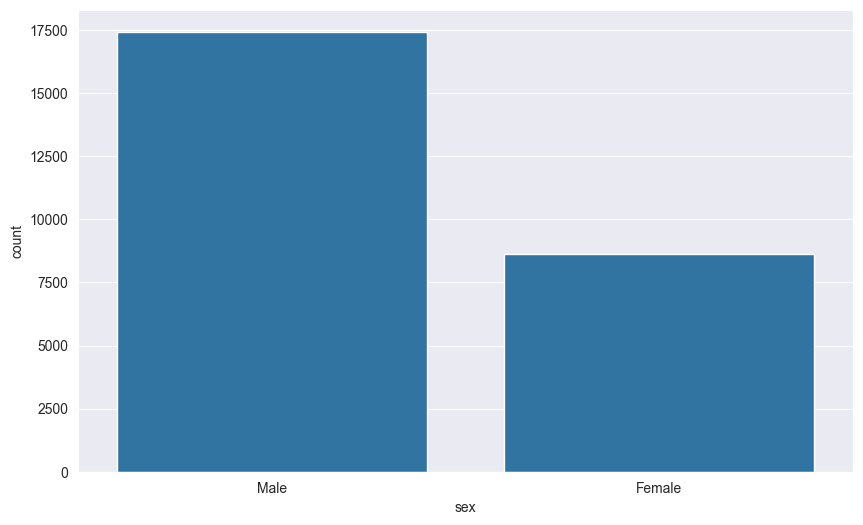

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(df_cat, x='sex')

<Axes: xlabel='native-country', ylabel='count'>

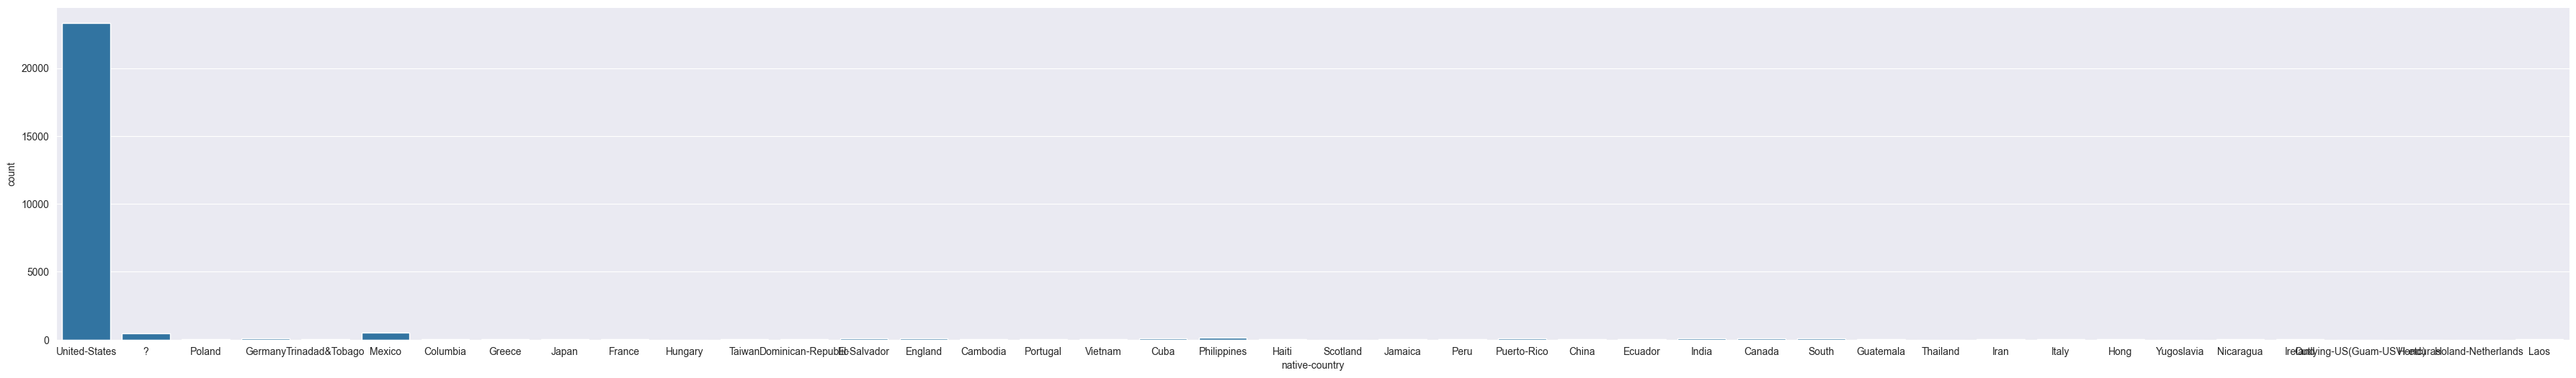

In [17]:
plt.figure(figsize=(45, 6))
sns.countplot(df_cat, x='native-country')

## Удаление пропущенных значений

Определите число строк исходного набора данных (без колонок <code>education</code> и <code>marital-status</code>), в которых присутствует хотя бы одно пропущенное значение.

In [18]:
ind = df[(df['workclass'] == '?') | (df['occupation'] == '?') | (df['native-country'] == '?')].index

Видно, что в датасете содержится менее 10% строк, содержащих пропуски. Выкидывать такое количество строк — не очень хорошее дело, но почему бы не попробовать обойтись без них.

Удалите строки, содеражащие пропуски. Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>.

Введите число полученных признаков.

In [19]:
df_no_del = df

df = df.drop(ind)

df = df.drop(columns=df_cat.columns)
dummies = pd.get_dummies(df_cat, drop_first=True)

df[dummies.columns] = dummies

Обучите модель классификации аналогично тому, как это было проделано для базовой модели. Вычислите <code>f1_score()</code> модели.



In [20]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='label'), df['label'], test_size=0.2, random_state=11, stratify=df['label'])

In [21]:
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [22]:
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)

prediction = neigh.predict(X_test)
f1_score(y_test, prediction)

0.6232846392208942

Точность модели увеличилась по сравнению с моделью, которая использовала только числовые признаки.

## Заполнение пропущенных значений

Возможно точность еще повысится, если задействовать строки с пропущенными значениями. Используя исходный датасет (без колонок <code>education</code> и <code>marital-status</code>), заполните пропуски самым часто встречающимся значением в рамках столбца.

In [23]:
mis_replacer = SimpleImputer(missing_values = '?', strategy='most_frequent')

df_cat = pd.DataFrame(mis_replacer.fit_transform(df_cat), columns=df_cat.columns)

Далее по уже знакомому сценарию: <code>one-hot</code>, <code>split</code>, <code>scaling</code>, обучение и оценка.

Вычислите <code>f1_score()</code> модели.

In [24]:
df_no_del = df_no_del.drop(columns=df_cat.columns)
dummies = pd.get_dummies(df_cat, drop_first=True)

df_no_del[dummies.columns] = dummies

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_no_del.drop(columns='label'), df_no_del['label'], test_size=0.2, random_state=11, stratify=df_no_del['label'])

In [26]:
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [27]:
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)

prediction = neigh.predict(X_test)
f1_score(y_test, prediction)

0.6137610806247362

## Проклятие размерности

В последнем пункте был получен набор данных, содержащий 76 признаков (кстати, попробуйте объяснить, почему в случае удаления строк число признаков в итоге оказалось равным 75), что является достаточным для того, чтобы столкнуться с так называемым проклятием размерности.

Для того, чтобы классификатор давал более качественные результаты, имеет смысл более внимательно и вдумчиво поработать с признаками с учетом проклятия размерности. Например, вернуть в рассмотрение признаки <code>education-num</code> и <code>marital-status</code>. А также более глубоко вникнуть в саму природу признаков.